In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
OUT_DIR = "/content/drive/MyDrive/DACNTT/DataAfterProcessing"

PRODUCTS_FINAL_PATH    = os.path.join(OUT_DIR, "products_final.csv")
TRANSACTIONS_LONG_PATH = os.path.join(OUT_DIR, "transactions_long.csv")
ITEM_RULES_PATH        = os.path.join(OUT_DIR, "item_rules.csv")
CATEGORY_RULES_PATH    = os.path.join(OUT_DIR, "category_rules.csv")

# Chuẩn hoá product_id / bill_id về string

In [4]:
# ST1 — Load products_final, transactions_long, item_rules, category_rules
# Chuẩn hoá product_id / bill_id về string để join không lỗi

def std_id(x):
    if pd.isna(x):
        return ""
    return str(x).strip().upper()

# Đọc products & transactions dưới dạng chuỗi
products = pd.read_csv(PRODUCTS_FINAL_PATH, dtype=str)
transactions = pd.read_csv(TRANSACTIONS_LONG_PATH, dtype=str)

# Chuẩn hoá ID
products["product_id"]   = products["product_id"].map(std_id)
transactions["product_id"] = transactions["product_id"].map(std_id)
transactions["bill_id"]    = transactions["bill_id"].map(lambda v: str(v).strip())

# Đọc luật (có thể rỗng)
try:
    item_rules = pd.read_csv(ITEM_RULES_PATH)
except Exception:
    item_rules = pd.DataFrame()

try:
    category_rules = pd.read_csv(CATEGORY_RULES_PATH)
except Exception:
    category_rules = pd.DataFrame()

# Tổng quan dữ liệu

In [5]:
# ST2 — Tổng quan dữ liệu: số bill, số sản phẩm, số ngành hàng

# Số bill
n_bills = transactions["bill_id"].nunique()

# Số sản phẩm trong catalog & trong bill
n_products_total = products["product_id"].nunique()
tx_products      = transactions["product_id"].unique()
n_products_in_tx = len(tx_products)

# Join transaction với products để gắn category
tx_with_cat = transactions.merge(
    products[["product_id", "category"]],
    on="product_id",
    how="left"
)

# Số ngành hàng trong catalog & xuất hiện thực tế
if "category" in products.columns:
    n_categories_total = products["category"].nunique()
else:
    n_categories_total = 0

if "category" in tx_with_cat.columns:
    n_categories_in_tx = tx_with_cat["category"].nunique()
else:
    n_categories_in_tx = 0

print("===== TỔNG QUAN DỮ LIỆU =====")
print(f"Tổng số hoá đơn (bill):           {n_bills}")
print(f"Tổng số sản phẩm trong catalog:   {n_products_total}")
print(f"Sản phẩm xuất hiện trong bill:    {n_products_in_tx} "
      f"({n_products_in_tx / max(1, n_products_total):.2%} catalog)")

print(f"Tổng số ngành hàng (catalog):     {n_categories_total}")
print(f"Ngành hàng xuất hiện trong bill:  {n_categories_in_tx} "
      f"({n_categories_in_tx / max(1, n_categories_total):.2%} catalog)")

===== TỔNG QUAN DỮ LIỆU =====
Tổng số hoá đơn (bill):           4430
Tổng số sản phẩm trong catalog:   12854
Sản phẩm xuất hiện trong bill:    6638 (51.64% catalog)
Tổng số ngành hàng (catalog):     261
Ngành hàng xuất hiện trong bill:  216 (82.76% catalog)


In [6]:
# Phân bố kích thước giỏ (bill size: số sản phẩm / bill)

basket_sizes = transactions.groupby("bill_id")["product_id"].nunique()

print("===== KÍCH THƯỚC GIỎ HÀNG =====")
print(f"Số bill: {len(basket_sizes)}")
print(f"Min sản phẩm / bill:      {basket_sizes.min()}")
print(f"Max sản phẩm / bill:      {basket_sizes.max()}")
print(f"Trung bình sản phẩm/bill: {basket_sizes.mean():.2f}")
print(f"Median sản phẩm/bill:     {basket_sizes.median():.2f}")

for q in [0.25, 0.5, 0.75, 0.9, 0.95]:
    print(f"Percentile {int(q*100):>2}%: {basket_sizes.quantile(q):.2f}")


===== KÍCH THƯỚC GIỎ HÀNG =====
Số bill: 4430
Min sản phẩm / bill:      5
Max sản phẩm / bill:      21
Trung bình sản phẩm/bill: 12.35
Median sản phẩm/bill:     12.00
Percentile 25%: 9.00
Percentile 50%: 12.00
Percentile 75%: 15.00
Percentile 90%: 18.00
Percentile 95%: 19.00


# Histogram kích thước giỏ hàng

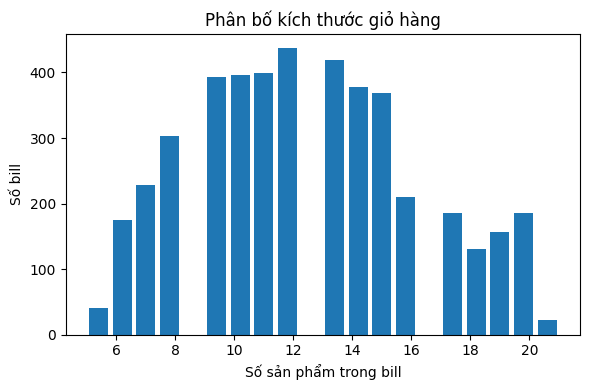

In [7]:
# ST3 — Histogram kích thước giỏ hàng (tuỳ chọn trực quan)

plt.figure(figsize=(6,4))
plt.hist(basket_sizes, bins=20, rwidth=0.8)
plt.xlabel("Số sản phẩm trong bill")
plt.ylabel("Số bill")
plt.title("Phân bố kích thước giỏ hàng")
plt.tight_layout()
plt.show()

# Tần suất theo sản phẩm

In [8]:
# ST4 — Tần suất theo sản phẩm: top sản phẩm, long-tail

item_freq = transactions["product_id"].value_counts()

# Join meta (tên, category)
prod_meta = products.set_index("product_id")[["product_name", "category"]]
item_freq_df = item_freq.to_frame(name="count").join(prod_meta, how="left").reset_index()
item_freq_df.rename(columns={"index": "product_id"}, inplace=True)

only_once    = (item_freq == 1).sum()
at_most_3    = (item_freq <= 3).sum()
at_least_10  = (item_freq >= 10).sum()

print("===== TẦN SUẤT THEO SẢN PHẨM =====")
print(f"Tổng sản phẩm xuất hiện trong bill: {len(item_freq)}")
print(f"Sản phẩm chỉ xuất hiện 1 lần:       {only_once} ({only_once/len(item_freq):.2%})")
print(f"Sản phẩm xuất hiện <= 3 lần:         {at_most_3} ({at_most_3/len(item_freq):.2%})")
print(f"Sản phẩm xuất hiện >= 10 lần:        {at_least_10} ({at_least_10/len(item_freq):.2%})")

print("\nTop 10 sản phẩm xuất hiện nhiều nhất:")
display(
    item_freq_df
      .sort_values("count", ascending=False)
      .head(100)[["product_id","product_name","category","count"]]
)

===== TẦN SUẤT THEO SẢN PHẨM =====
Tổng sản phẩm xuất hiện trong bill: 6638
Sản phẩm chỉ xuất hiện 1 lần:       603 (9.08%)
Sản phẩm xuất hiện <= 3 lần:         3495 (52.65%)
Sản phẩm xuất hiện >= 10 lần:        1352 (20.37%)

Top 10 sản phẩm xuất hiện nhiều nhất:


,product_id,product_name,category,count
0,8935311112642,phở trộn long triều hải sản cay vifon gói 90g,"Phở, Bún Ăn Liền",578
1,8935311112635,phở trộn long triều bò tái lăn vifon gói 90g,"Phở, Bún Ăn Liền",564
2,8801045571867,miến ăn liền vị udon ottogi ly 38.1g,"Phở, Bún Ăn Liền",549
3,8801045571577,miến ăn liền vị lẩu cay ottogi ly 38.1g,"Phở, Bún Ăn Liền",546
4,8801045512518,miến ăn liền ottogi vị lẩu cay tê mala hộp 44.7g,"Phở, Bún Ăn Liền",511
...,...,...,...,...
96,8993053121032,khăn giấy rút paseo 2 lớp gói 220 tờ,Khăn Giấy,52
95,8936020761954,lốc 2 cây giấy vệ sinh elène đỏ không lõi 3 lớ...,Giấy Vệ Sinh,52
98,8935018801832,giấy vệ sinh pulppy velvet hương hoa 2 lớp 2 cuộn,Giấy Vệ Sinh,51
97,8935018801597,giấy vệ sinh pulppy classic 2 lớp lốc 9 cuộn,Giấy Vệ Sinh,51


# Thống kê về ngành hàng (category)

In [9]:
# ST5 — Ngành hàng: số sản phẩm/nhóm và số dòng giao dịch

# Số sản phẩm trong từng ngành hàng
cat_item_counts = (products
                   .groupby("category")["product_id"]
                   .nunique()
                   .sort_values(ascending=False))

# Số dòng giao dịch theo ngành (dùng tx_with_cat đã join ở ST2)
cat_tx_counts = (tx_with_cat
                 .groupby("category")["bill_id"]
                 .count()
                 .sort_values(ascending=False))

cat_stats = (pd.DataFrame({
    "num_products": cat_item_counts,
    "num_lines_in_bills": cat_tx_counts
})
 .fillna(0)
 .astype({"num_products": int, "num_lines_in_bills": int})
 .sort_values("num_lines_in_bills", ascending=False)
)

print("===== NGÀNH HÀNG =====")
print(f"Tổng số ngành hàng trong catalog: {cat_stats.shape[0]}")

print("\nTop 10 ngành hàng xuất hiện nhiều nhất trong bill:")
display(cat_stats.head(10))


===== NGÀNH HÀNG =====
Tổng số ngành hàng trong catalog: 261

Top 10 ngành hàng xuất hiện nhiều nhất trong bill:


,num_products,num_lines_in_bills
category,,
"Phở, Bún Ăn Liền",103,3360
"Cơm, Cháo, Canh Ăn Liền",85,3344
Bánh Snack,248,2595
"Nước Súc Miệng, Xịt Thơm Miệng",33,2269
Nước Giặt,90,2238
"Xả Vải, Xịt Vải",73,2209
Khăn Giấy,71,2157
Sữa Tắm,220,2046
Bàn Chải Đánh Răng,82,2037


# Thống kê luật theo Hàng (item)

In [10]:
# ST6 — Thống kê luật theo SẢN PHẨM (item_rules)

if item_rules is None or item_rules.empty:
    print("Không có item_rules (file rỗng hoặc không tồn tại).")
else:
    n_item_rules = len(item_rules)
    print("===== LUẬT SẢN PHẨM (ITEM RULES) =====")
    print(f"Tổng số luật: {n_item_rules}")

    for col in ["support","confidence","lift"]:
        if col in item_rules.columns:
            s = item_rules[col]
            print(f"\nThống kê {col}:")
            print(f"  Min:   {s.min():.4f}")
            print(f"  Max:   {s.max():.4f}")
            print(f"  Mean:  {s.mean():.4f}")
            print(f"  25%:   {s.quantile(0.25):.4f}")
            print(f"  50%:   {s.quantile(0.50):.4f}")
            print(f"  75%:   {s.quantile(0.75):.4f}")

    # Chọn cột hiển thị linh hoạt (tuỳ phiên bản item_rules)
    cols_show = []
    for c in ["antecedent_id","antecedent_name","consequent_id","consequent_name",
              "antecedents","consequents","support","confidence","lift"]:
        if c in item_rules.columns:
            cols_show.append(c)

    print("\nTop 10 luật theo lift (mạnh nhất):")
    display(
        item_rules
          .sort_values("lift", ascending=False)
          .head(10)[cols_show]
    )


===== LUẬT SẢN PHẨM (ITEM RULES) =====
Tổng số luật: 184

Thống kê support:
  Min:   0.0032
  Max:   0.0381
  Mean:  0.0245
  25%:   0.0212
  50%:   0.0240
  75%:   0.0269

Thống kê confidence:
  Min:   0.1505
  Max:   0.3140
  Mean:  0.2332
  25%:   0.2024
  50%:   0.2324
  75%:   0.2623

Thống kê lift:
  Min:   1.8732
  Max:   7.6455
  Mean:  2.2660
  25%:   2.0839
  50%:   2.2077
  75%:   2.3114

Top 10 luật theo lift (mạnh nhất):


,antecedent_id,antecedent_name,consequent_id,consequent_name,support,confidence,lift
0,8936037367163,kem hấp dầu m-pros phục hồi tóc khô xơ hương p...,8850273275313,nước súc miệng mondahmin hương bạc hà pepper m...,0.003160,0.179487,7.645464
1,8850007816645,nước súc miệng listerine cho răng nhạy cảm khô...,8801051018035,nước súc miệng bamboo salt muối hồng himalaya ...,0.003160,0.150538,6.875069
2,8801045303017,cháo ăn liền ottogi thịt bò nấm bào ngư nhật h...,8936049053320,cháo tươi ottogi nếp cẩm đậu đỏ gói 220g,0.023025,0.252475,2.714722
3,8936049053320,cháo tươi ottogi nếp cẩm đậu đỏ gói 220g,8801045303017,cháo ăn liền ottogi thịt bò nấm bào ngư nhật h...,0.023025,0.247573,2.714722
4,8801045303000,cháo ăn liền ottogi bào ngư hộp 285g,8801045303062,cháo ăn liền ottogi gà dinh dưỡng hộp 285g,0.023251,0.251220,2.675246
5,8801045303062,cháo ăn liền ottogi gà dinh dưỡng hộp 285g,8801045303000,cháo ăn liền ottogi bào ngư hộp 285g,0.023251,0.247596,2.675246
6,8801047161608,cháo ăn liền vị thịt bò dongwon tô 288g,8935311110921,cháo ăn liền vifon vị cá gói 50g,0.025508,0.279012,2.646734
7,8935311110921,cháo ăn liền vifon vị cá gói 50g,8801047161608,cháo ăn liền vị thịt bò dongwon tô 288g,0.025508,0.241970,2.646734
8,8934863404106,cháo gạo lứt bích chi 50g,8801047161608,cháo ăn liền vị thịt bò dongwon tô 288g,0.020767,0.234694,2.567145
9,8801047161608,cháo ăn liền vị thịt bò dongwon tô 288g,8934863404106,cháo gạo lứt bích chi 50g,0.020767,0.227160,2.567145


# Thống kê luật theo Ngành hàng (category)

In [11]:
# ST7 — Thống kê luật theo NGÀNH HÀNG (category_rules)

if category_rules is None or category_rules.empty:
    print("Không có category_rules (file rỗng hoặc không tồn tại).")
else:
    n_cat_rules = len(category_rules)
    print("===== LUẬT NGÀNH HÀNG (CATEGORY RULES) =====")
    print(f"Tổng số luật: {n_cat_rules}")

    for col in ["support","confidence","lift"]:
        if col in category_rules.columns:
            s = category_rules[col]
            print(f"\nThống kê {col}:")
            print(f"  Min:   {s.min():.4f}")
            print(f"  Max:   {s.max():.4f}")
            print(f"  Mean:  {s.mean():.4f}")
            print(f"  25%:   {s.quantile(0.25):.4f}")
            print(f"  50%:   {s.quantile(0.50):.4f}")
            print(f"  75%:   {s.quantile(0.75):.4f}")

    print("\nTop 10 luật ngành hàng theo lift:")
    display(
        category_rules
          .sort_values("lift", ascending=False)
          .head(10)[["category_A","category_B","support","confidence","lift"]]
    )

===== LUẬT NGÀNH HÀNG (CATEGORY RULES) =====
Tổng số luật: 1711

Thống kê support:
  Min:   0.0032
  Max:   0.3229
  Mean:  0.0261
  25%:   0.0054
  50%:   0.0102
  75%:   0.0254

Thống kê confidence:
  Min:   0.1509
  Max:   1.0000
  Mean:  0.4332
  25%:   0.2301
  50%:   0.3415
  75%:   0.6646

Thống kê lift:
  Min:   1.0253
  Max:   5.3119
  Mean:  2.2543
  25%:   2.0363
  50%:   2.1912
  75%:   2.3909

Top 10 luật ngành hàng theo lift:


,category_A,category_B,support,confidence,lift
0,Đường,Hạt Sấy Khô,0.006548,0.233871,5.311869
1,Giấy Vệ Sinh,Khăn Giấy,0.180853,0.945691,4.921814
2,Khăn Giấy,Giấy Vệ Sinh,0.180853,0.941246,4.921814
3,Sữa Rửa Mặt,"Bánh, Ngũ Cốc",0.004290,0.322034,4.754294
4,"Gối, Ruột Gối, Vỏ Gối",Giấy Vệ Sinh,0.019192,0.904255,4.728391
5,"Gối, Ruột Gối, Vỏ Gối",Khăn Giấy,0.018966,0.893617,4.650799
6,Khăn Ướt,Giấy Vệ Sinh,0.051705,0.870722,4.553046
7,Giấy Vệ Sinh,Khăn Ướt,0.051705,0.270366,4.553046
8,"Xả Vải, Xịt Vải",Giấy Vệ Sinh,0.181531,0.841885,4.402252
9,Giấy Vệ Sinh,"Xả Vải, Xịt Vải",0.181531,0.949233,4.402252


# Tóm tắt dữ liệu

In [12]:
# ST8 — Tóm tắt nhanh “câu chuyện dữ liệu”

print("===== TÓM TẮT NHANH =====")
print(f"- Dữ liệu gồm {n_bills} hoá đơn, {n_products_in_tx} sản phẩm thực sự được mua "
      f"trên tổng số {n_products_total} sản phẩm trong catalog.")
print(f"- Có {n_categories_in_tx} / {n_categories_total} ngành hàng xuất hiện trong giao dịch thực tế.")

if item_rules is not None and not item_rules.empty:
    print(f"- Hệ thống sinh được {len(item_rules)} luật mua chung theo MẶT HÀNG (item-item).")
if category_rules is not None and not category_rules.empty:
    print(f"- Hệ thống sinh được {len(category_rules)} luật mua chung theo NGÀNH HÀNG (category-category).")

print("- Phân tích kích thước giỏ cho thấy số sản phẩm/bill dao động từ "
      f"{basket_sizes.min()} đến {basket_sizes.max()}, trung bình {basket_sizes.mean():.2f} sản phẩm mỗi lần mua.")
print("- Tần suất xuất hiện cho thấy có một nhóm sản phẩm/ngành hàng xuất hiện rất thường xuyên "
      "và một long-tail sản phẩm chỉ xuất hiện vài lần.")


===== TÓM TẮT NHANH =====
- Dữ liệu gồm 4430 hoá đơn, 6638 sản phẩm thực sự được mua trên tổng số 12854 sản phẩm trong catalog.
- Có 216 / 261 ngành hàng xuất hiện trong giao dịch thực tế.
- Hệ thống sinh được 184 luật mua chung theo MẶT HÀNG (item-item).
- Hệ thống sinh được 1711 luật mua chung theo NGÀNH HÀNG (category-category).
- Phân tích kích thước giỏ cho thấy số sản phẩm/bill dao động từ 5 đến 21, trung bình 12.35 sản phẩm mỗi lần mua.
- Tần suất xuất hiện cho thấy có một nhóm sản phẩm/ngành hàng xuất hiện rất thường xuyên và một long-tail sản phẩm chỉ xuất hiện vài lần.
